In [1]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dades = read_csv('dadesBaellsMulti.csv', sep=';',header=0, index_col=0)

vol = dades['Volum']
tm = dades['TM']
hrm = dades['HRM']
ppt = dades['PPT']
pm = dades['PM']

# convert to [rows, columns] structure
vol = vol.reshape((len(vol), 1))
tm = tm.reshape((len(tm), 1))
hrm = hrm.reshape((len(hrm), 1))
ppt = ppt.reshape((len(ppt), 1))
pm = pm.reshape((len(pm), 1))


# horizontally stack columns
dataset = hstack((vol,tm,hrm,ppt,pm,vol))

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(dataset)

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  de

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [4]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [5]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [6]:
n_steps_in = 30
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [7]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

In [11]:
from scipy.stats import uniform
from scipy.stats import randint
dense=[]
epochs=[]
lr=[]
batch=[]
num_repeticions=250

for i in range(num_repeticions):
    dense.append(randint.rvs(5, 500))
    epochs.append(randint.rvs(50, 1200))
    lr.append(uniform.rvs(0.0001, 0.01))
    batch.append(randint.rvs(8, 128))



In [14]:
from keras import optimizers
#Simulació RandomizedSearchCV per SVM
resultat=[]

for den, epoch, l_r, bat in zip(dense, epochs, lr, batch):
    adam = optimizers.Adam(lr=l_r)
    model = Sequential()
    model.add(Dense(den, activation='sigmoid', input_dim=n_input))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
    # fit model
    modelfit = model.fit(train_X, train_Y, epochs=epoch, batch_size=bat, verbose=0)
    # Predict on new data
    yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,den, epoch, l_r, bat)
    resultat.append((den, epoch, l_r, bat, RMSE_days,RMSE_TOT))
                 
    

3.7295471947148386 376 637 0.0047829252445274655 67
3.3828237341513425 498 455 0.001652741042150485 11
3.036649611031345 203 246 0.0020442891050068634 90
3.8171070173671175 365 1125 0.004334611621109535 127
3.52846404811889 346 959 0.0063551590299818 39
3.7704716740313406 496 841 0.007136341411246876 100
3.7046805208360336 152 229 0.003322987834311346 107
3.340491411265135 34 504 0.005762337555385577 77
3.214638509466832 448 347 0.0022033725506624144 53
3.021547831680788 194 94 0.008951037031429033 54
3.5799993974099085 422 917 0.007066231693354486 65
3.1186627102158084 279 450 0.008231910141914869 118
3.5248537845194337 199 951 0.006962765265209362 87
3.486476567904435 377 1037 0.0015388612957246061 29
3.696284821501143 458 746 0.007886938127283282 8
3.6921872501006985 242 106 0.009556536892135592 105
2.886980732152101 325 543 0.0003667339520597378 95
3.2090858944476404 30 431 0.0067389911150563765 92
3.1900105948528674 402 528 0.006962772454804077 16
3.532178862336587 219 648 0.00162

3.129871598066404 21 576 0.0068590672231517175 75
3.7592981640743126 123 975 0.008206512137305992 33
3.246887065531972 197 254 0.006715142421359382 51
3.240051733180617 171 983 0.0076703813692564245 30
3.543968726368877 204 142 0.004785101759188975 28
4.040130003596096 447 1126 0.002974978201190982 95
3.969516680486234 446 546 0.006420638072716458 20
3.482553490410014 124 433 0.010019403276499564 48
3.788287838670353 493 1030 0.0040935859662831345 73
3.8359369722824685 217 401 0.009919972542968145 84
3.644933223155584 117 1034 0.002789289996773918 100
2.975201000455193 213 127 0.0037032330853936945 105
3.3625322786714675 40 806 0.003424767241280392 126
3.288644582379484 148 662 0.005917299073528163 41
3.135470998845122 169 927 0.0004970012312080041 68
3.6022986459445345 312 742 0.0036396064812677996 85
2.988205822963973 128 91 0.0012357283101558359 103
3.580808849929611 119 724 0.004352226252080819 100
3.563297694278828 239 823 0.002646793255167744 114
3.0329144217689605 293 317 0.0011

In [17]:
varlist = []
for i in range(len(dense)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['nº neurones','epochs',  'learning rate','batch size', 'RMSE_dayws', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,nº neurones,epochs,learning rate,batch size,RMSE_dayws,RMSE_total
0,483,422,0.000238,97,"[0.9244955538044215, 1.0682606667981356, 1.331...",2.756819
1,167,434,0.001266,114,"[0.8769002767166655, 1.0399314764615877, 1.282...",2.763687
2,430,779,0.000319,99,"[0.8916208962719478, 1.06233891148041, 1.37258...",2.775957
3,414,488,0.000172,72,"[0.9209908090844989, 0.9892790250891047, 1.294...",2.800929
4,382,144,0.002713,61,"[1.0600329187424873, 1.277085401417648, 1.4740...",2.822224
5,297,281,0.002000,106,"[1.1710537463247936, 1.164344596318793, 1.4146...",2.842028
6,6,942,0.002715,114,"[1.0484797356229163, 1.186131622271991, 1.3416...",2.871348
7,178,356,0.001041,111,"[0.8719719997023364, 1.5239386946122848, 1.363...",2.885767
8,325,543,0.000367,95,"[1.6486243957732587, 1.679668807015321, 1.5938...",2.886981
9,293,146,0.000575,99,"[1.2940993989290086, 1.3828422057140146, 1.669...",2.887478


In [24]:
adam = optimizers.Adam(lr=0.000238)
model = Sequential()
model.add(Dense(483, activation='sigmoid', input_dim=n_input))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer=adam)
# fit model
modelfit = model.fit(train_X, train_Y, epochs=422, batch_size=97, verbose=0)
# Predict on new data
yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)

In [25]:
print(RMSE_TOT)

2.7966249900130857


In [26]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

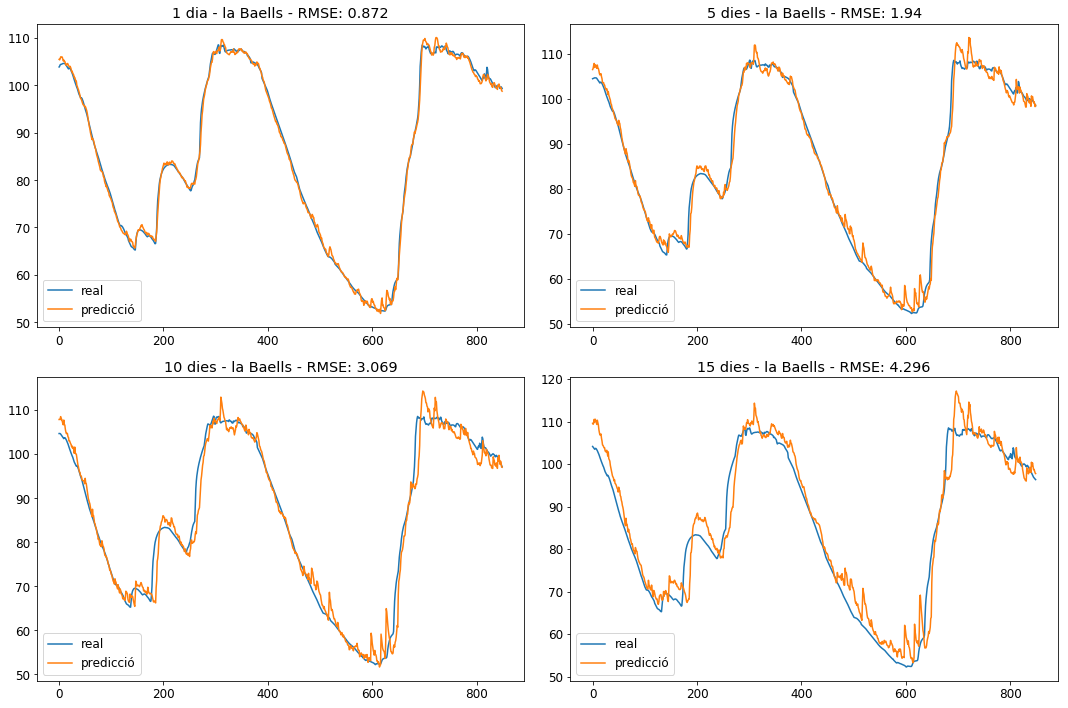

In [27]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [28]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒══════════╤═════════╤═════════╤═════════╤═════════╕
│    dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪═════════╪═════════╪═════════╪═════════╡
│ 0.872046 │ 1.10641 │ 1.38393 │ 1.60615 │  1.9397 │
╘══════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 2.11154 │ 2.37627 │ 2.60276 │ 2.84777 │  3.06886 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  3.23311 │   3.6072 │  3.77217 │  4.06422 │  4.29595 │ 2.79662 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [8]:
import numpy as np
from keras import optimizers
n_steps_in = np.arange(5,101,2)
resultat = []
n_steps_out = 15
propTrainTest = 0.8

for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    adam = optimizers.Adam(lr=0.000238)
    model = Sequential()
    model.add(Dense(483, activation='sigmoid', input_dim=n_input))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
    # fit model
    modelfit = model.fit(train_X, train_Y, epochs=422, batch_size=97, verbose=0)
    # Predict on new data
    yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

3.2198698951398947 5
2.9806900699998775 7
3.142264267708246 9
2.6864355945678713 11
2.6945031229253242 13
2.662089647089647 15
2.7276312393016777 17
2.7846839669985393 19
2.702773708074054 21
2.996313134171814 23
2.7948884874617717 25
2.997006116082989 27
3.242892580224977 29
3.3667485911068495 31
2.9596506820572963 33
2.9795587409090993 35
2.8460134790426928 37
2.92857083089015 39
2.950607773388135 41
2.9153473985491445 43
3.134186635989611 45
2.9732587557398173 47
2.933150931003124 49
2.8972349373434154 51
3.1695601348007654 53
3.1307796018394733 55
3.0634483505039456 57
3.2689033462317263 59
3.1672611586895134 61
3.720468108457162 63
2.962819069684685 65
2.934541370992761 67
3.177497919386063 69
2.9753607270841953 71
3.0835778209730975 73
2.980542394782288 75
2.9516035454288785 77
3.1505070041243934 79
3.0106853785442915 81
2.9789041828979848 83
2.9849896845980823 85
2.970742567047058 87
2.9460906952909007 89
3.358660185940199 91
3.0787953042539082 93
3.074846058661526 95
3.25772415

In [11]:
varlist = []
for i in range(len(resultat)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['entrades', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,entrades,RMSE_total
0,15,2.662090
1,11,2.686436
2,13,2.694503
3,21,2.702774
4,17,2.727631
5,19,2.784684
6,25,2.794888
7,37,2.846013
8,51,2.897235
9,43,2.915347


In [12]:
import numpy as np
from keras import optimizers
n_steps_in = np.arange(10,21,1)
resultat = []
n_steps_out = 15
propTrainTest = 0.8

for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    adam = optimizers.Adam(lr=0.000238)
    model = Sequential()
    model.add(Dense(483, activation='sigmoid', input_dim=n_input))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
    # fit model
    modelfit = model.fit(train_X, train_Y, epochs=422, batch_size=97, verbose=0)
    # Predict on new data
    yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

2.8573023389821115 10
2.6730413710301746 11
2.672523917363381 12
2.7073335874793094 13
2.815122308895965 14
2.707625116606526 15
2.879279508822238 16
2.9361476021177526 17
2.7258291124517138 18
2.695056100134667 19
2.736644427070729 20


In [14]:
from scipy.stats import uniform
from scipy.stats import randint
n_steps_in = 11
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

dense=[]
epochs=[]
lr=[]
batch=[]
num_repeticions=500

for i in range(num_repeticions):
    dense.append(randint.rvs(5, 500))
    epochs.append(randint.rvs(50, 1000))
    lr.append(uniform.rvs(0.0001, 0.01))
    batch.append(randint.rvs(8, 128))


In [15]:
from keras import optimizers
#Simulació RandomizedSearchCV per SVM
resultat=[]

for den, epoch, l_r, bat in zip(dense, epochs, lr, batch):
    adam = optimizers.Adam(lr=l_r)
    model = Sequential()
    model.add(Dense(den, activation='sigmoid', input_dim=n_input))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
    # fit model
    modelfit = model.fit(train_X, train_Y, epochs=epoch, batch_size=bat, verbose=0)
    # Predict on new data
    yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,den, epoch, l_r, bat)
    resultat.append((den, epoch, l_r, bat, RMSE_days,RMSE_TOT))
                 

2.960262228038459 68 230 0.006128079136201656 53
2.8942919792070065 492 456 0.0037885119749661487 52
2.9023348425886595 269 429 0.004579794779323029 16
2.8693391182167263 70 963 0.0015502885827573675 26
2.8375065947313116 188 512 0.002362893241943955 97
2.9192247659565114 82 71 0.0047743388613796355 67
2.954542171580581 90 399 0.009236206806608615 33
2.856057511063698 430 865 0.0025001942631448504 55
3.0348321463867354 275 990 0.002642254474143394 30
3.05292990807164 235 776 0.001978588971539946 24
3.083089437567315 436 374 0.006464088263287739 83
2.9131004087841155 251 441 0.00898571241482589 73
2.7756924024343563 264 290 0.002072399077325275 116
2.9055746838806358 456 646 0.006288924583969783 54
2.9374185950249756 354 760 0.009425624050239702 74
2.8602226337642502 388 114 0.00778837925135297 21
3.2686438892591188 224 897 0.006677699185365041 17
2.643489338226147 21 258 0.0033993509204553814 99
2.660694464232694 499 801 0.0036276362411471197 55
2.7261779752236714 206 930 0.00045057586

2.6858433595224587 84 306 0.0034126146086841144 101
2.945855192450403 335 528 0.004740425308233799 54
4.4357718987038 442 119 0.009939448060318759 126
3.206417936632126 451 803 0.008472771897528177 84
3.045444069500084 363 150 0.002290728010507734 75
3.479143823365748 448 382 0.00229976953905151 19
2.748481151349695 70 335 0.000699015552543305 84
2.952479575336101 265 554 0.0020286234512262346 49
2.7207138288573574 210 212 0.003257585282915879 45
2.7779527181730566 423 457 0.0008945405387260585 115
2.7410021326172744 226 476 0.009532717975325466 66
2.740450628326132 489 422 0.0012037570352088078 79
2.92217873208312 86 219 0.0032859495551537687 17
3.3737036741955153 430 355 0.005684550801546253 66
2.8711447163238684 202 324 0.008425240907518517 82
2.914108766606453 37 838 0.00475058007556611 114
2.6045430203922253 15 850 0.0021712723746873637 32
3.402869892177812 241 449 0.0013055421802534962 109
2.8431021087234907 269 553 0.0023056084000151497 19
2.774023037595056 52 117 0.004293529145

3.002810336562407 436 614 0.007403094833500055 21
3.221192930587391 82 898 0.003770333225703183 29
3.429607920171775 305 841 0.009692322553047568 104
2.7259084757537417 12 882 0.00934700669379242 72
3.1342639876715825 54 820 0.00904515912982957 74
2.9500642458726007 255 413 0.008593084357444943 19
2.748217474870996 444 324 0.003627234675835601 119
3.1465137878428213 151 462 0.0019995680299161986 54
3.2058540078552125 179 500 0.0037664205462659916 53
2.7647681850279855 190 878 0.0008395617597278726 37
3.3984359247592564 14 171 0.0023813062694297126 28
2.7157257886964037 302 611 0.002661689008940883 108
2.967594071016047 442 119 0.0011872881109759382 123
3.153460509987602 46 785 0.006913759493770476 44
2.8862932425340992 366 609 0.005089463938143478 39
2.7764917648771448 248 722 0.004205984463367411 109
2.8101474411268126 67 432 0.008500744151611868 81
2.7027957215326652 126 926 0.0005760544594584827 121
2.7684227358059297 17 259 0.0035807931126102307 120
2.7595973990507994 311 247 0.001

2.9665618299364613 257 852 0.009227391865866543 126
2.9544294924287486 463 828 0.0009989209924593134 89
2.795332554338486 496 272 0.003892430828296759 92
2.6362460515403945 414 176 0.006369776806863849 46
3.3197841978853377 295 283 0.0028900123649574627 112
2.835923905972878 179 236 0.0046249364505743865 27
3.3855079004311115 213 189 0.0022514999272377364 115
3.032139046124145 357 142 0.007360654860682199 41
2.7926414204448364 421 638 0.0025325793310156095 52
3.044254617765823 428 874 0.009423918159125466 90
2.7655101215912925 395 772 0.0008098165871983908 37
3.0195872769289394 260 186 0.008221967602072814 31
2.7647506178322803 205 420 0.0060626509517135675 44


In [16]:
varlist = []
for i in range(len(dense)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['nº neurones','epochs',  'learning rate','batch size', 'RMSE_dayws', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,nº neurones,epochs,learning rate,batch size,RMSE_dayws,RMSE_total
0,5,773,0.001267,47,"[0.8327415596125376, 0.9543133935720437, 1.165...",2.581784
1,5,782,0.001188,36,"[1.0514311998093664, 1.0652026864801158, 1.214...",2.598301
2,15,850,0.002171,32,"[1.053180946852176, 1.0873570425465076, 1.1721...",2.604543
3,52,948,0.004735,52,"[0.7365506512259771, 0.9706685303313929, 1.207...",2.626215
4,36,340,0.002521,43,"[0.7177650789908904, 0.9279908292068485, 1.169...",2.636127
5,414,176,0.006370,46,"[0.8276841512899165, 1.0068745956284464, 1.230...",2.636246
6,55,451,0.006295,122,"[0.8019501639007101, 1.017779487013822, 1.2738...",2.642549
7,21,258,0.003399,99,"[0.816618486705984, 0.9262961637844339, 1.1946...",2.643489
8,49,501,0.002170,64,"[0.7237049841635722, 0.9181824031919245, 1.163...",2.644987
9,193,660,0.001422,104,"[0.6970284171604835, 1.0385236463197267, 1.168...",2.645896


In [24]:
n_steps_in = 11
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))


adam = optimizers.Adam(lr=0.001267)
model = Sequential()
model.add(Dense(5, activation='sigmoid', input_dim=n_input))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer=adam)
# fit model
modelfit = model.fit(train_X, train_Y, epochs=773, batch_size=47, verbose=0)
# Predict on new data
yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

2.6122315469296957


In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [51]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
print(RMSE_days)

[(0.8578945260504494, 0.9977966980572632, 0.6686238958965638, 0.7359830178273252), (1.036916730897209, 0.9967796409011924, 0.7759549085924684, 1.075196306814555), (1.1619826607342698, 0.9959535040917317, 0.7920053176633347, 1.3502037038470933), (1.4487154148966648, 0.9937055544725256, 0.9793793780416172, 2.0987763533592156), (1.702099973118725, 0.9913046128576499, 1.1046447380051982, 2.8971443184907644), (1.9050860981072706, 0.9891002198666147, 1.2227922041406498, 3.629353041201585), (2.182735109041618, 0.9856821255233154, 1.4316314585263465, 4.764332556242924), (2.4250676524533885, 0.9823136189663265, 1.5940512585655506, 5.880953118975789), (2.702038407472435, 0.9780261603993213, 1.7680018488623037, 7.301011555456171), (2.867007049123939, 0.9752415260719617, 1.8645201484982272, 8.219729419726358), (3.242772880690856, 0.9683004320099794, 2.22091202737799, 10.515575955744072), (3.33747727008463, 0.966393684119662, 2.22431927907523, 11.138754528331553), (3.555297661946399, 0.961831156139

In [27]:
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

print(round(rmse,4))
print(mse)
print(mae)
print(r_quad)

2.6122
6.823753654774736
1.6147510823570745
0.9794733594705188


In [36]:
res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,0.8579,1.0369,1.1620,1.4487,1.7021,1.9051,2.1827,2.4251,2.702,2.8670,3.2428,3.3375,3.5553,3.7207,4.0330,2.6122
R2,0.9978,0.9968,0.9960,0.9937,0.9913,0.9891,0.9857,0.9823,0.978,0.9752,0.9683,0.9664,0.9618,0.9582,0.9508,0.9795
MAE,0.6686,0.7760,0.7920,0.9794,1.1046,1.2228,1.4316,1.5941,1.768,1.8645,2.2209,2.2243,2.3916,2.4489,2.7339,1.6148
MSE,0.7360,1.0752,1.3502,2.0988,2.8971,3.6294,4.7643,5.8810,7.301,8.2197,10.5156,11.1388,12.6401,13.8438,16.2654,6.8238


In [52]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

2.6122315469296957


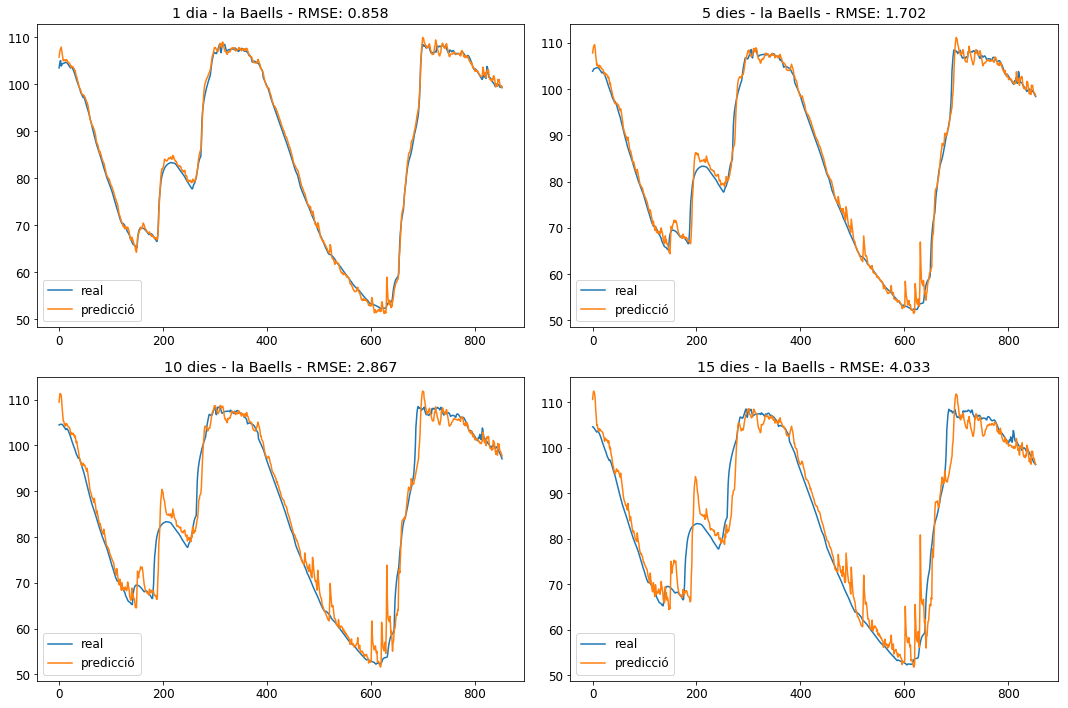

In [39]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [53]:
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,0.858,1.037,1.162,1.449,1.702,1.905,2.183,2.425,2.702,2.867,3.243,3.337,3.555,3.721,4.033,2.612


In [54]:
resultsDF.to_csv('mlp-multi-baells.csv', sep=',', encoding='utf-8')

In [55]:
resultatsDEF=[]
for i, j in zip (test_YR, testPredict):
    resultatsDEF.append((i,j))
    
resultatsDEF = pd.DataFrame(resultatsDEF)
resultatsDEF.columns=['ytest','predict']
resultatsDEF.to_csv('mlp-multi-baells-test-predict.csv', sep=',', encoding='utf-8')